In [120]:
import nltk
import json
import os
import re
import pandas as pd

nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/minlee/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [121]:
def get_industry_category(sic_code):
    """
    Maps SIC codes to industry categories based on predefined ranges.
    """
    sic_code = int(sic_code)  # Ensure it's an integer
    if 1 <= sic_code <= 999:
        return "Agriculture, Forestry and Fishing"
    elif 1000 <= sic_code <= 1499:
        return "Mining"
    elif 1500 <= sic_code <= 1799:
        return "Construction"
    elif 2000 <= sic_code <= 3999:
        return "Manufacturing"
    elif 4000 <= sic_code <= 4999:
        return "Transportation and Utilities"
    elif 5000 <= sic_code <= 5199:
        return "Wholesale Trade"
    elif 5200 <= sic_code <= 5999:
        return "Retail Trade"
    elif 6000 <= sic_code <= 6799:
        return "Finance, Insurance and Real Estate"
    elif 7000 <= sic_code <= 8999:
        return "Services"
    elif 9000 <= sic_code <= 9999:
        return "Public Administration"
    else:
        return "Unknown"


In [122]:
data_path = "./10K_item1a_PERMNO_2015_sic_tic"

# Store metadata
file_metadata = []

for file in os.listdir(data_path):
    if file.endswith(".json"):
        file_path = os.path.join(data_path, file)
        try:
            with open(file_path, "r", encoding="utf-8") as f:
                data = json.load(f)
                if "SIC" in data and "filing_date" in data:
                    industry = get_industry_category(data["SIC"])
                    year = data["filing_date"][:4]  # Extract year from date
                    file_metadata.append({"file": file_path, "industry": industry, "year": year})
        except json.JSONDecodeError:
            print(f"Error reading {file}")

# Convert metadata to a DataFrame
df = pd.DataFrame(file_metadata)
print(df.head())  # Preview metadata

                                                file  \
0  ./10K_item1a_PERMNO_2015_sic_tic/0001193125-20...   
1  ./10K_item1a_PERMNO_2015_sic_tic/0000049754-21...   
2  ./10K_item1a_PERMNO_2015_sic_tic/0000023197-16...   
3  ./10K_item1a_PERMNO_2015_sic_tic/0001085392-16...   
4  ./10K_item1a_PERMNO_2015_sic_tic/0000313716-18...   

                             industry  year  
0                       Manufacturing  2020  
1  Finance, Insurance and Real Estate  2021  
2                       Manufacturing  2016  
3        Transportation and Utilities  2016  
4                       Manufacturing  2018  


In [123]:
# Randomly sample up to 10 firms per (year, industry) without including grouping columns
sampled_files = (
    df.groupby(["year", "industry"], group_keys=False)
    .apply(lambda x: x.sample(min(10, len(x)), random_state=42)[["file"]])  # Explicitly select "file" column
)

# Reset index to avoid multi-index issues
sampled_files = sampled_files.reset_index(drop=True)

# Get final list of files to process
selected_files = sampled_files["file"].tolist()
print(f"Selected {len(selected_files)} JSON files for processing.")


Selected 775 JSON files for processing.


/var/folders/ry/yln3jdq12pq_cv5j4g53cd0w0000gp/T/ipykernel_64518/4161413360.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(10, len(x)), random_state=42)[["file"]])  # Explicitly select "file" column


In [124]:
relevant_keywords = {
    "attack": ["cyber-", "cyber" "networks", "systems", "products", "services", "datacenter", "infrastructure"],
    "threat": ["cyber-", "cyber", "networks", "systems", "products", "services", "datacenter", "infrastructure"],
    "computer": ["malware", "virus", "viruses", "intrusions"],
    "information system": ["malware", "virus", "viruses", "intrusions"],
    "malicious": ["software", "programs", "third parties", "attacks"],
    "breaches": [],
    "hacker": [],
    "hacking": [],
    "social engineering": [],
    "denial of service": [],
    "cyberattack": [],
    "cybersecurity": [],

}

irrelevant_keywords = {
    "attack": ["terror", "war", "contraband", "bombs"],
    "threat": ["terror", "simulator", "disease", "legal action", "competitors"],
    "computer": ["fires", "product sales", "warranty claim"],
    "information system": ["fires", "product sales", "warranty claim"],
    "malicious": [],
    "breaches": ["fiduciary duty", "covenant", "credit", "agreement"],
    "hacker": ["fiduciary", "warranty", "regulations", "contract"],
    "hacking": ["fiduciary", "warranty", "regulations", "contract"],
    "social engineering": ["fiduciary", "warranty", "regulations", "contract"],
    "denial of service": ["fiduciary", "warranty", "regulations", "contract"],
    "cyberattack": ["fiduciary", "warranty", "regulations", "contract"],
    "cybersecurity": ["fiduciary", "warranty", "regulations", "contract"],
}

In [125]:
def classify_sentences(sentences):
    """
    Strictly filters cybersecurity-related sentences using keyword relevance and irrelevant word exclusion.
    Ensures that secondary words (e.g., "products") only trigger when their parent keyword (e.g., "attack") is present.
    """
    relevant_sentences_per_file = {}

    for filename, sentence in sentences:
        lower_sentence = sentence.lower()
        is_relevant = False  # Assume not relevant initially

        # **Step 1: Check if the sentence contains a keyword**
        for category, keywords in relevant_keywords.items():
            # **Primary keyword must be present first (e.g., "attack")**
            if re.search(rf"\b{re.escape(category)}(s|ing|ed)?\b", lower_sentence):  # Check base keyword first
                # **Step 2: If it has required relevant words, ensure at least one is present**
                relevant_words = relevant_keywords[category]
                if relevant_words:  # If not empty, enforce relevance
                    if not any(re.search(rf"\b{re.escape(word)}(s|ing|ed)?\b", lower_sentence) for word in relevant_words):
                        continue  # Skip if no required relevant words are found
                
                # **Step 3: Exclude if sentence contains any irrelevant words**
                if category in irrelevant_keywords:  # Only check if irrelevant words exist
                    irrelevant_words = irrelevant_keywords[category]
                    if any(re.search(rf"{re.escape(word)}(s|ing|ed)?", lower_sentence) for word in irrelevant_words):
                        is_relevant = False  # Reset before breaking
                        break  # Stop further checks since the sentence should be excluded

                # **Step 4: Mark as relevant if all conditions pass**
                is_relevant = True
                break  

        # **Step 5: Save relevant sentences per file**
        if is_relevant:
            if filename not in relevant_sentences_per_file:
                relevant_sentences_per_file[filename] = []
            relevant_sentences_per_file[filename].append(sentence)

    return relevant_sentences_per_file


In [126]:
from tqdm import tqdm
import time


# Ensure output directory exists
output_dir = "./output/"
os.makedirs(output_dir, exist_ok=True)

def process_file(file_path):
    """
    Reads a JSON file, extracts cybersecurity-related sentences, and saves them in ./output/.
    """
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)
            if "item_1A" not in data:
                return None

            text = data["item_1A"]
            sentences = sent_tokenize(text)  # Tokenize text into sentences
            filename = os.path.basename(file_path).replace(".json", "")

            # **Pass (filename, sentence) pairs to classify_sentences()**
            sentence_pairs = [(filename, sent) for sent in sentences]
            relevant_sentences_per_file = classify_sentences(sentence_pairs)

            # **Save extracted sentences**
            output_file = os.path.join(output_dir, f"{filename}_filtered.txt")
            with open(output_file, "w", encoding="utf-8") as f:
                for sent in relevant_sentences_per_file.get(filename, []):  # Get relevant sentences
                    f.write(sent + "\n")

            return len(relevant_sentences_per_file.get(filename, []))  # Return count for summary reporting

    except json.JSONDecodeError:
        print(f"Error reading {file_path}")
        return None

# **Run processing in a simple loop with a progress bar**
start_time = time.time()

results = []
for file_path in tqdm(selected_files, desc="Processing Files", unit="file"):
    result = process_file(file_path)
    results.append(result)

end_time = time.time()
print(f"Processed {len(selected_files)} files in {end_time - start_time:.2f} seconds.")


Processing Files: 100%|██████████| 775/775 [00:11<00:00, 67.05file/s]

Processed 775 files in 11.56 seconds.


In [127]:
# Use the previously selected 10 random JSON files per (year, industry)
selected_files_set = set(os.path.basename(file) for file in selected_files)  # Keep only filenames

# List to store cybersecurity risk data
cybersecurity_risk_data = []

# Iterate only through the selected JSON files
for json_file in tqdm(selected_files_set, desc="Processing Selected Files", unit="file"):
    file_id = json_file.replace(".json", "")  # Extract base filename
    filtered_file_path = os.path.join("./output", f"{file_id}_filtered.txt")  # Locate filtered file

    # Count the number of lines (sentences) in the filtered file
    if os.path.exists(filtered_file_path):
        with open(filtered_file_path, "r", encoding="utf-8") as f:
            cyber_sentence_count = sum(1 for _ in f)  # Count lines in filtered file
    else:
        cyber_sentence_count = 0  # No cybersecurity sentences found

    # Store results
    cybersecurity_risk_data.append({
        "file": json_file,
        "cybersecurity_risk_count": cyber_sentence_count
    })

# Convert to DataFrame and display results
df_cyber_risk = pd.DataFrame(cybersecurity_risk_data)
df_cyber_risk.head(15)  # Preview the results


Processing Selected Files: 100%|██████████| 775/775 [00:00<00:00, 38597.28file/s]


,file,cybersecurity_risk_count
0,0000726854-15-000007.json,6
1,0000703604-15-000022.json,3
2,0000745981-16-000082.json,5
3,0001574596-17-000012.json,0
4,0001493152-21-023342.json,0
5,0001564590-21-059499.json,26
6,0001255474-22-000008.json,37
7,0001193125-15-072217.json,3
8,0001490906-16-000135.json,8
9,0001619954-20-000026.json,29


### Why I Selected Option 2?
I believe that option 2, the count of sentences identified as direct descriptions of cybersecurity risk as a standalone measure
is better, because it shows an absolute number of how many sentences are related to cybersecurity. If it was a proportion, if there were a lot of
sentences but had a single very important sentence with details about cybersecurity risks, it would have a very low percentage,
which could underlook the significance of that sentence. Having a certain number of sentences that could be reviewed would help
more in identifying key sentences as it provides how many to look for.

However, it would be best to have both the counts and percentage.

In [128]:
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# Load metadata containing SIC codes and years
metadata_df = pd.DataFrame(file_metadata)  # Ensure this contains 'file', 'industry' (SIC), and 'year'
metadata_df["file"] = metadata_df["file"].apply(lambda x: os.path.basename(x))
metadata_df_filtered = metadata_df[metadata_df["file"].isin(df_cyber_risk["file"])]
print('filtered 10 per each year and industry')
print(metadata_df_filtered.head())

# Ensure df_cyber_risk has the right column names
df_cyber_risk = df_cyber_risk.rename(columns={"file": "file", "cybersecurity_risk_count": "cybersecurity_risk_count"})
print('counts of sentences')
print(df_cyber_risk.head())

# Merge metadata with cybersecurity sentence counts
final_df = metadata_df_filtered.merge(df_cyber_risk, on="file")

# Convert year to integer
final_df["year"] = final_df["year"].astype(int)
print('merged')
print(final_df.head())



filtered 10 per each year and industry
                          file               industry  year
8    0000912061-16-000018.json        Wholesale Trade  2016
53   0001437749-15-004253.json        Wholesale Trade  2015
105  0001144204-17-014369.json  Public Administration  2017
182  0000891024-20-000008.json        Wholesale Trade  2020
239  0001437749-21-004259.json        Wholesale Trade  2021
counts of sentences
                        file  cybersecurity_risk_count
0  0000726854-15-000007.json                         6
1  0000703604-15-000022.json                         3
2  0000745981-16-000082.json                         5
3  0001574596-17-000012.json                         0
4  0001493152-21-023342.json                         0
merged
                        file               industry  year  \
0  0000912061-16-000018.json        Wholesale Trade  2016   
1  0001437749-15-004253.json        Wholesale Trade  2015   
2  0001144204-17-014369.json  Public Administration  2017   


In [129]:
# Compute descriptive statistics for cybersecurity risk by industry
def compute_descriptive_stats(df):
    stats = df.groupby("industry")["cybersecurity_risk_count"].agg(
        Count="count",
        Mean="mean",
        Std_Dev="std",
        Skewness=lambda x: skew(x, bias=False) if len(x) > 1 else np.nan,
        Kurtosis=lambda x: kurtosis(x, bias=False) if len(x) > 1 else np.nan,
        Min="min",
        Max="max",
        P1=lambda x: np.percentile(x, 1),
        P5=lambda x: np.percentile(x, 5),
        P25=lambda x: np.percentile(x, 25),
        Median=lambda x: np.percentile(x, 50),  # Median
        P75=lambda x: np.percentile(x, 75),
        P95=lambda x: np.percentile(x, 95),
        P99=lambda x: np.percentile(x, 99),
    ).round(2)  # Round for better readability

    return stats

# Compute statistics
descriptive_stats = compute_descriptive_stats(final_df)

# Display results in a formatted table
print("\nDescriptive Statistics for Cybersecurity Risk by Industry:\n")
print(descriptive_stats.to_string(index=True))  # Ensure full table is printed



Descriptive Statistics for Cybersecurity Risk by Industry:

                                    Count   Mean  Std_Dev  Skewness  Kurtosis  Min  Max   P1   P5   P25  Median    P75    P95    P99
industry                                                                                                                            
Agriculture, Forestry and Fishing      55   4.47     5.26      2.40      7.11    0   26  0.0  0.0  1.00     3.0   6.00  11.90  24.92
Construction                           80   3.85     3.91      2.63     12.00    0   26  0.0  0.0  1.00     3.0   6.00   9.05  15.73
Finance, Insurance and Real Estate     80  10.62    16.28      3.84     17.45    0  106  0.0  0.0  3.75     6.0  10.00  40.20  80.72
Manufacturing                          80   4.03     6.09      4.38     23.97    0   43  0.0  0.0  1.00     2.5   5.00  10.05  31.94
Mining                                 80   7.16    11.37      3.00      9.90    0   64  0.0  0.0  1.75     4.0   6.25  31.30  50.57
Public A

## Observations

### Industries with High Cybersecurity Risk Mentions
- Services: Highest with a mean of 12.84 mentions, and a maximum of 84. This shows that companies within this industry such as IT firms and consulting businesses have a strong emphasis on cybersecurity, which seems natural as they rely on data and digital infrastructure which is crucial to their operation.
- Finance, Insurance and Real Estate: Has an average of 10.62 mentions, with a maximum of 106. This aligns with the industry's sensitivity of financial data, which cybersecurity is a key risk factor.
- Mining: Relatively high concern for cybersecurity, with an average of 7.16 mentions and a maximum of 64. This may be due to the increasing digitalization of mining operations, making them vulnerable to cybersecurity attacks.

### Industries with Low Cybersecurity Risk Mentions
Public Administration, Construction, and Agriculture, Forestry and Fishing show a much lower frequency of cybersecurity risk discussions. This could be
due to the fact that cybersecurity threats are not a key primary risk in these sectors, and focus more on physical security and operational risks.

### Skewness and Variability in Cybersecurity Discussions
Interestingly, quite uneven distributions are present in fields such as Manufacturing (Skewness: 4.38, Kurtosis: 23.97) and Finance (Skewness: 3.84, Kurtosis: 17.45). This suggests that even though some firms in these industries discuss cybersecurity often, the majority do not bring it up. This incredibly uneven distribution distinctly points out specific firm cybersecurity awareness more so than a common industry standard.

The percentile distribution backs up this point, too. In many sectors, the 1st as well as 5th percentiles are at zero. This shows that some companies do not bring up cybersecurity risk at all, along with in sectors where it may be very important, such as Finance and Manufacturing. However, at the 95th and also 99th percentiles, the numbers go up a lot, suggesting that some firms focus a lot on cybersecurity risk.



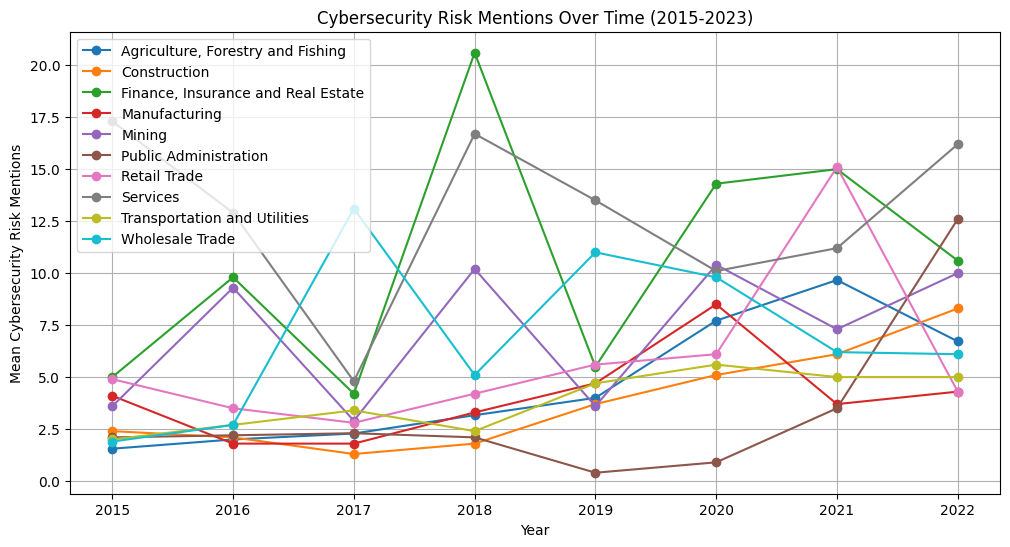

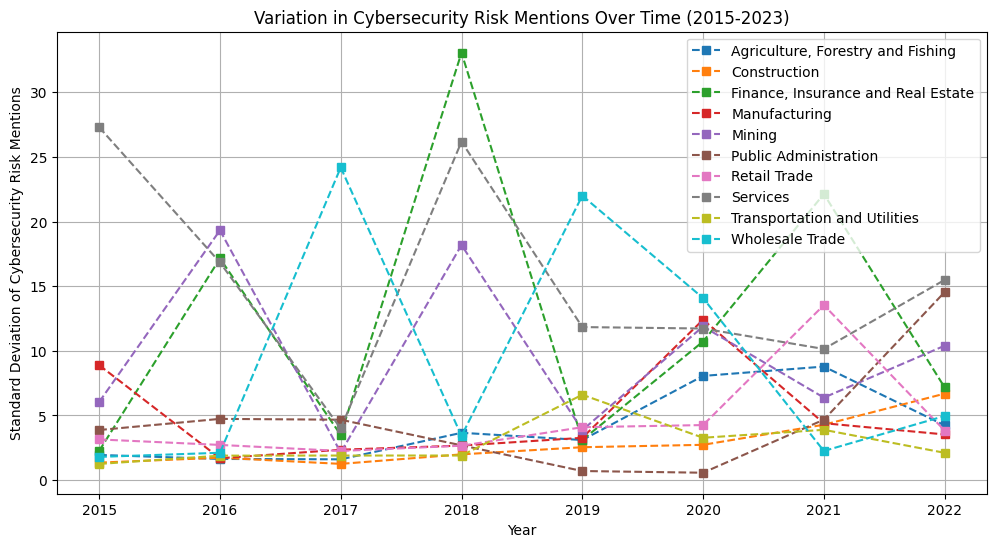

In [130]:
import matplotlib.pyplot as plt

# Compute mean and std by industry and year
trend_stats = final_df.groupby(["year", "industry"])["cybersecurity_risk_count"].agg(
    mean="mean",
    std="std"
).reset_index()

# Plot mean cybersecurity risk mentions over time
plt.figure(figsize=(12, 6))

for industry in trend_stats["industry"].unique():
    industry_data = trend_stats[trend_stats["industry"] == industry]
    plt.plot(industry_data["year"], industry_data["mean"], marker="o", linestyle="-", label=industry)

plt.xlabel("Year")
plt.ylabel("Mean Cybersecurity Risk Mentions")
plt.title("Cybersecurity Risk Mentions Over Time (2015-2023)")
plt.legend()
plt.grid(True)
plt.show()

# **Separate plot for standard deviation**
plt.figure(figsize=(12, 6))

for industry in trend_stats["industry"].unique():
    industry_data = trend_stats[trend_stats["industry"] == industry]
    plt.plot(industry_data["year"], industry_data["std"], marker="s", linestyle="--", label=industry)

plt.xlabel("Year")
plt.ylabel("Standard Deviation of Cybersecurity Risk Mentions")
plt.title("Variation in Cybersecurity Risk Mentions Over Time (2015-2023)")
plt.legend()
plt.grid(True)
plt.show()


## Observations for Mean and Standard Deviation

We can observe that the mean and the standard deviation closely align graph-wise, and that some industries have correlating "spikes" along with time.

The most noticable aspect in the graph we can observe that there was a big spike in the increase of mentions in 2018, for Finance, Insurance, Real Estate, and Services. This might be due to the increase in cybersecurity attacks in 2018. There were attacks from cybercriminal groups such as Carbanak and Cobalt which target financial institutes, and also increase in supply chain attacks. These attacks used malware to penetrate networks and steal funds, so mentions regarding digital safety and how the companies in that sector are corresponding to the attacks would be naturally increased at that time.

We can also observe that the sectors of Finance, Insurance, Real Estate, and Services have a higher average mention of cybersercurity related topics.
As said within the observation in the comments for the table, these industries are very reliant in data, and cybersecurity attacks are crucial on their operation. This is the reason why the overall mentions of related topics are high consistently along the years.

We can also see a big spike in 2017 for the Wholesale Trade sector. This might be because of the Maersk, the world's largest container shipping company, being the victim for the NotPetya ransomware attack long over $300 million. This attack may have affected the majority of wholesale trading companies, as they are closely related to the operation of Maersk. This naturally would lead to a higher attention on cybersecurity related topics in 2017.